In [2]:
%load_ext autoreload
%autoreload 2

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tensorly.decomposition import parafac
import tensorly as ts


from src.random_baseline import compute_random_baseline
from models.classical_ml import knn, logistic_regression, random_forest, xgbc, voting_classifier, plot_feature_importances
from src.preprocessing import clean_df, complete_df, prepare_feature_target_matrices

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load the data under xlsx format
desc = pd.read_excel('data/Descriptif_patients.xlsx')
global_radio = pd.read_excel("data/radiomiques_global.xlsx") # "features" extraits de la segmentation 3D (donc associés à toute la lésion)
multislice = pd.read_excel("data/radiomiques_multislice.xlsx") #  "features" extraits de la segmentation 2D (donc associés à chaque coupe 2D où la lésion est présente)

### Data exploration

In [258]:
# Clean the data
desc_clean, global_radio_clean, multislice_clean = clean_df(desc, global_radio, multislice)

# Ensure only complete records are used
global_radio_complete, multislice_complete = complete_df(global_radio_clean, multislice_clean)

# Prepare feature and target matrices
X, y = prepare_feature_target_matrices(global_radio_complete)

# Outputs to verify
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

X.head()

Shape of X: (117, 428)
Shape of y: (117,)


,ART_original_firstorder_10Percentile,PORT_original_firstorder_10Percentile,VEIN_original_firstorder_10Percentile,TARD_original_firstorder_10Percentile,ART_original_firstorder_90Percentile,PORT_original_firstorder_90Percentile,VEIN_original_firstorder_90Percentile,TARD_original_firstorder_90Percentile,ART_original_firstorder_Energy,PORT_original_firstorder_Energy,...,VEIN_original_ngtdm_Complexity,TARD_original_ngtdm_Complexity,ART_original_ngtdm_Contrast,PORT_original_ngtdm_Contrast,VEIN_original_ngtdm_Contrast,TARD_original_ngtdm_Contrast,ART_original_ngtdm_Strength,PORT_original_ngtdm_Strength,VEIN_original_ngtdm_Strength,TARD_original_ngtdm_Strength
ID,,,,,,,,,,,,,,,,,,,,,
0,211.0,256.0,264.0,253.0,367.0,362.0,359.0,341.0,3.015106e+08,3.356713e+08,...,39.277987,38.563334,0.053328,0.014902,0.015188,0.013078,0.226864,0.534732,0.332041,0.379284
1,260.1,229.0,229.1,212.0,894.0,954.8,1144.7,1120.9,7.323840e+08,7.720563e+08,...,11442.875990,7286.155315,0.312577,0.370738,0.449753,0.514460,5.425102,5.795566,9.512513,6.745733
4,110.0,130.0,134.0,143.0,166.0,171.0,167.0,168.0,1.982289e+07,1.992656e+07,...,1.508313,1.566126,0.018048,0.012486,0.013621,0.009396,0.224467,0.121753,0.061704,0.053781
5,162.7,341.7,333.6,346.4,277.3,445.3,416.7,402.6,4.416506e+06,1.807627e+07,...,13.409998,7.369850,0.118901,0.086435,0.057493,0.086926,1.455775,1.305156,1.083879,0.645670
6,399.0,484.0,496.0,488.0,638.0,671.0,673.0,651.0,1.289387e+10,1.594912e+10,...,596.169662,493.969070,0.036039,0.020776,0.026698,0.024221,0.140786,0.236058,0.187567,0.157278


### PCA

(428, 428)


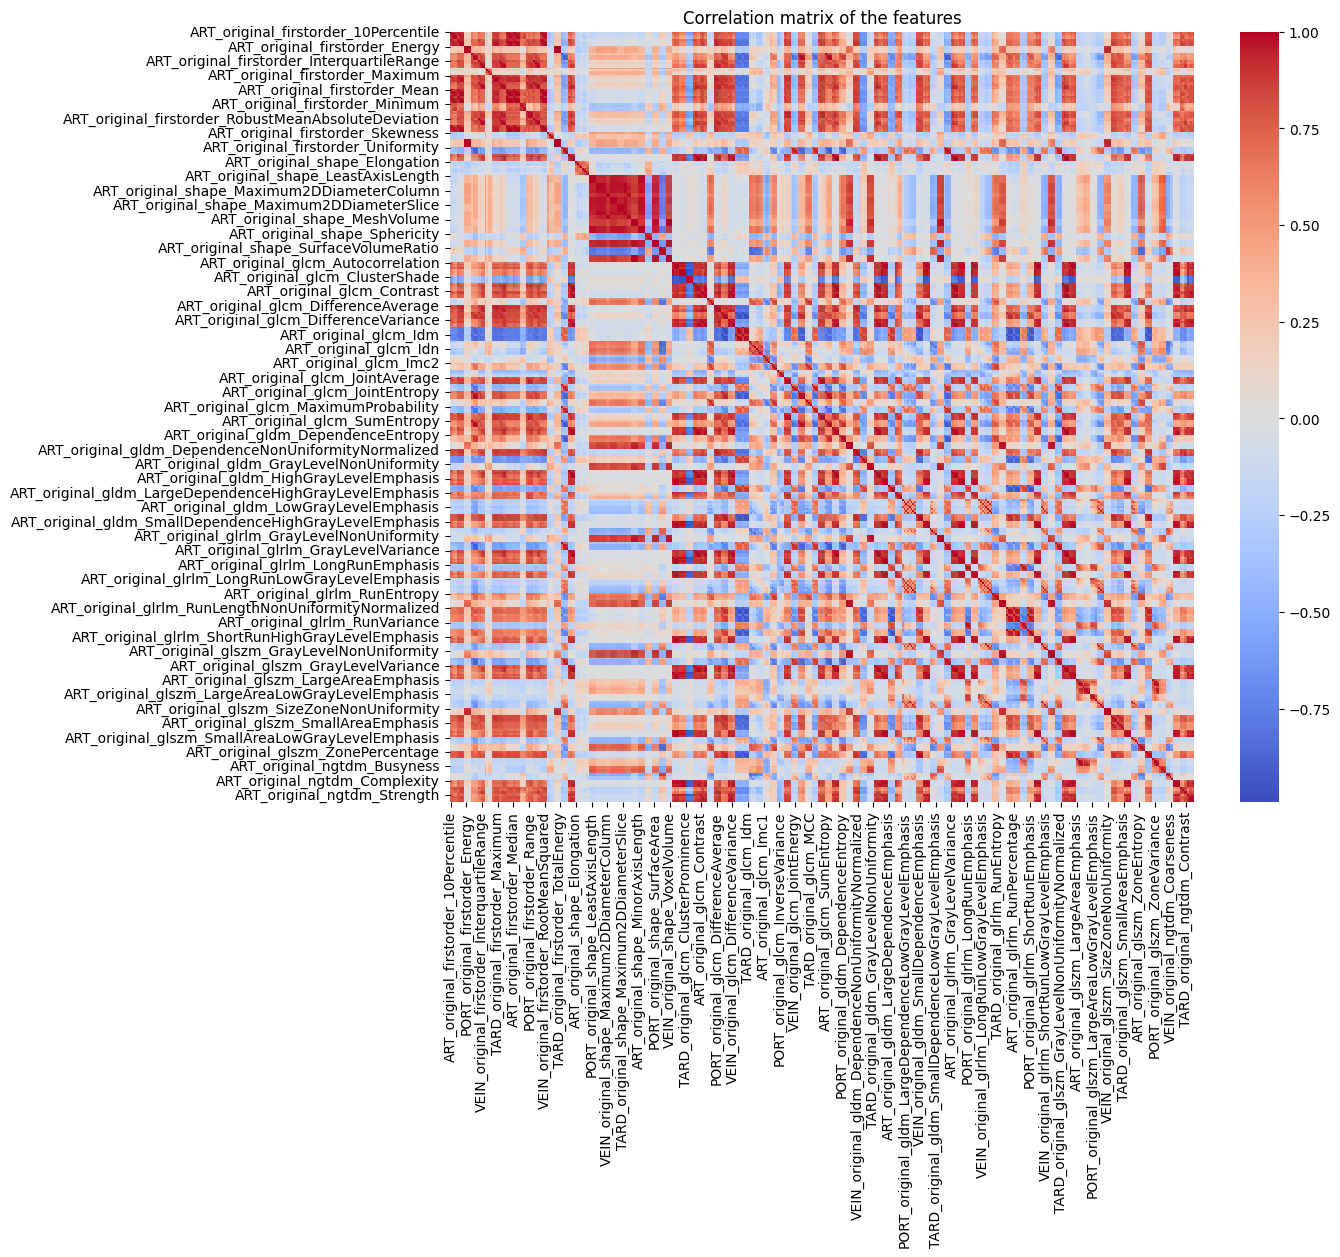

In [7]:
R = X.corr()
print(R.shape)
# visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(R, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix of the features")
plt.show()

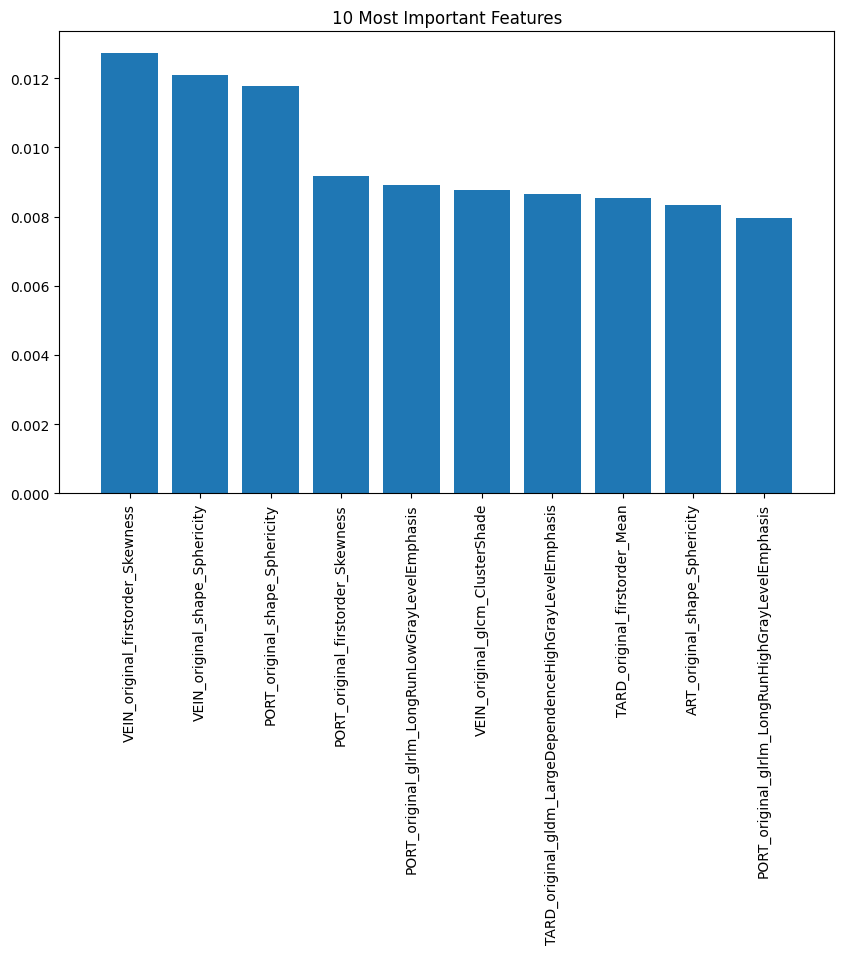

In [8]:
plot_feature_importances(X, y, k=10)

117


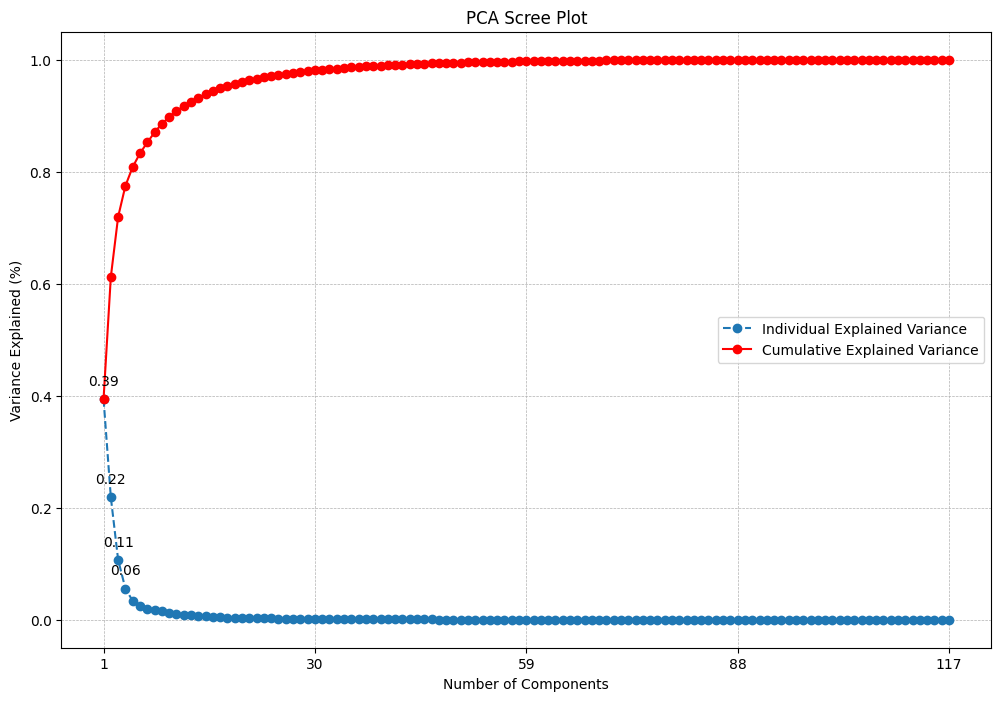

In [9]:
# Standardize the data
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Display the summary
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(len(explained_variance))

# Plot settings
plt.figure(figsize=(12, 8))
individual_line, = plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o--', label='Individual Explained Variance')
cumulative_line, = plt.plot(np.arange(1, len(explained_variance) + 1), cumulative_variance, 'o-', color='r', label='Cumulative Explained Variance')

plt.title('PCA Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained (%)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(handles=[individual_line, cumulative_line])

# Adjusting x-axis ticks to only show those components explaining at least 5% of variance
significant_components = np.linspace(1,len(explained_variance),5) #[i + 1 for i, v in enumerate(explained_variance) if v >= 0.05]
plt.xticks(significant_components)

# Annotate each significant point
for i, v in enumerate(explained_variance):
    if v >= 0.05:  # only annotate significant components
        label = f"{v:.2f}"
        plt.annotate(label, (i + 1, v), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()


The plot helps in determining the number of components to retain for further analysis. A common approach is to choose the number of components that add up to a substantial cumulative variance, typically around 70-90%. This is evident from where the cumulative variance curve begins to plateau.

PCA is effective in reducing dimensionality while retaining most of the information. If the first few components explain most of the variance, it implies that they capture most of the essential information present in the original features, allowing for a reduction in complexity without significant loss of information.

Here we only keep the first five components.

In [49]:
def pca_summary(pca_model):
    explained_variance = pca_model.explained_variance_ratio_
    singular_values = pca_model.singular_values_
    cumulative_variance = pca_model.explained_variance_ratio_.cumsum()

    print("Explained Variance Ratio per Component:")
    for i, variance in enumerate(explained_variance):
        print(f"Component {i+1}: {variance:.4f}")

    print("\nSingular Values:")
    for i, singular in enumerate(singular_values):
        print(f"Component {i+1}: {singular:.4f}")

    print("\nCumulative Explained Variance:")
    for i, cum_var in enumerate(cumulative_variance):
        print(f"Components 1-{i+1}: {cum_var:.4f}")

pca_summary(pca.fit(X_scaled))

Explained Variance Ratio per Component:
Component 1: 0.3940
Component 2: 0.2184

Singular Values:
Component 1: 140.4685
Component 2: 104.5691

Cumulative Explained Variance:
Components 1-1: 0.3940
Components 1-2: 0.6124


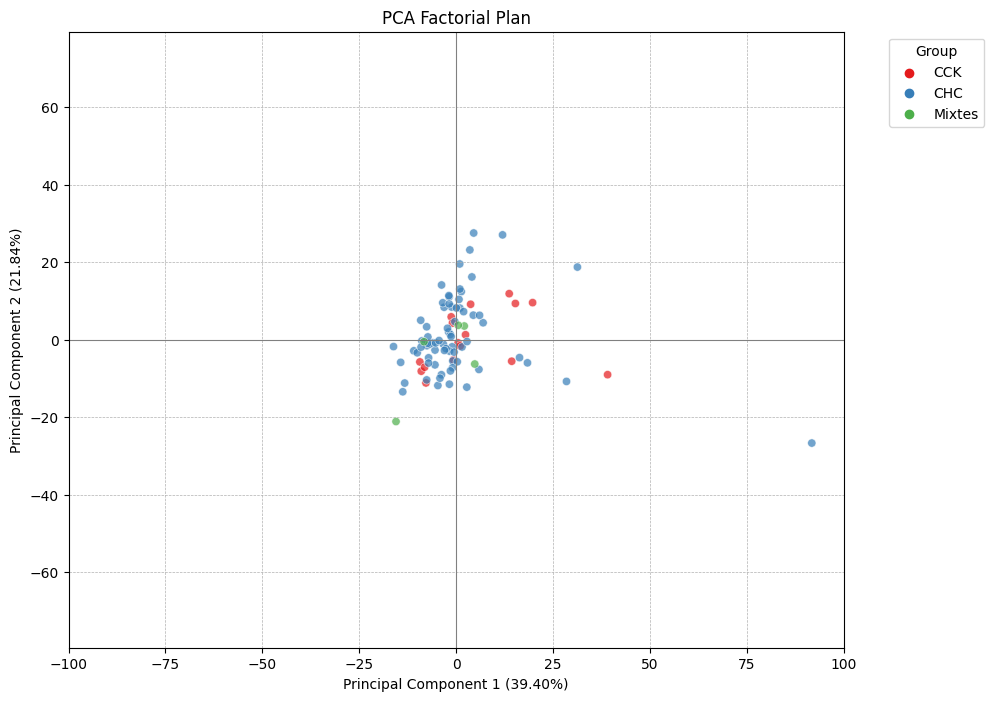

In [52]:
# Standardize the data
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Group'] = y  # Assuming 'y' is your categorical label

# Plotting
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(x='PC1', y='PC2', hue='Group', data=pca_df, palette='Set1', alpha=0.7)

# Set the aspect of the plot to be equal, to keep PC1 and PC2 on the same scale
plt.gca().set_aspect('equal', adjustable='datalim')
plt.title('PCA Factorial Plan')
plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}%)')

# Enhance the legend
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Draw a horizontal and vertical line passing through zero to better visualize the center
plt.axhline(0, color='grey', linewidth=0.8)
plt.axvline(0, color='grey', linewidth=0.8)

# Improve grid visibility and style
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(-100, 100)
plt.ylim(-80, 80)

plt.show()


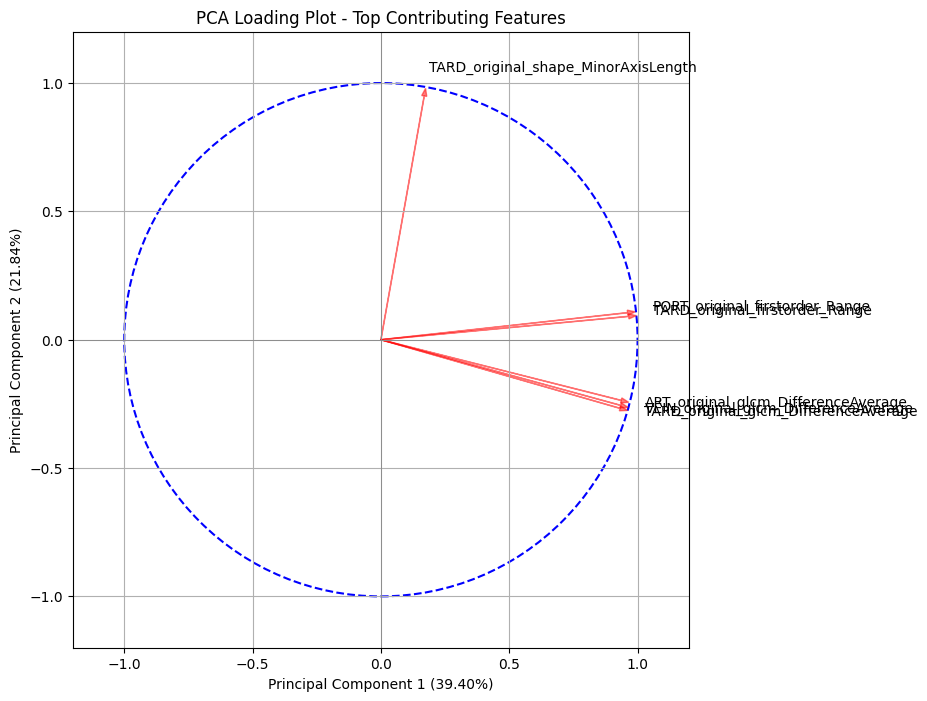

In [53]:
# Assuming X is already defined and contains your dataset
# Standardize the data
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_

# Calculate loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for easier manipulation
loading_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=X.columns)

# Calculate the magnitude of each vector
loading_df['Magnitude'] = np.sqrt(loading_df['PC1']**2 + loading_df['PC2']**2)

# Sort features by 'Magnitude' to get the most important ones
loading_df = loading_df.sort_values(by='Magnitude', ascending=False)

# How many top features to display
top_features = 6

# Plot settings
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Plot unit circle
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', linewidth=1.5)
ax.add_artist(circle)

# Plot only the most important features
for i, feature in enumerate(loading_df.index[:top_features]):
    vector = loading_df.loc[feature]
    ax.arrow(0, 0, vector['PC1'], vector['PC2'], color='r', alpha=0.5, head_width=0.02, head_length=0.03)
    plt.text(vector['PC1'] * 1.1, vector['PC2'] * 1.1, feature, fontsize=10)  # Slight offset for label

plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}%)')
plt.title('PCA Loading Plot - Top Contributing Features')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)

# Set limits to ensure the unit circle is completely visible
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal', adjustable='box')  # Ensure circle is round
plt.show()


It provides a visual representation of how each feature in the original dataset contributes to the principal components created by the PCA process.

Each vector (arrow) in the plot represents a feature, and the direction and length of the vector indicate how much and in which way the feature influences each principal component.

Features that point in similar directions may be positively correlated, while those in opposite directions might be negatively correlated.

Here for the top 6 features we can see that the most important features are 'original_firstorder_Range' and that their is strong correlation between features of the same type but different time occurence (e.g. ART, PORT, VEIN or TARD).

Best sparsity level: 1.0


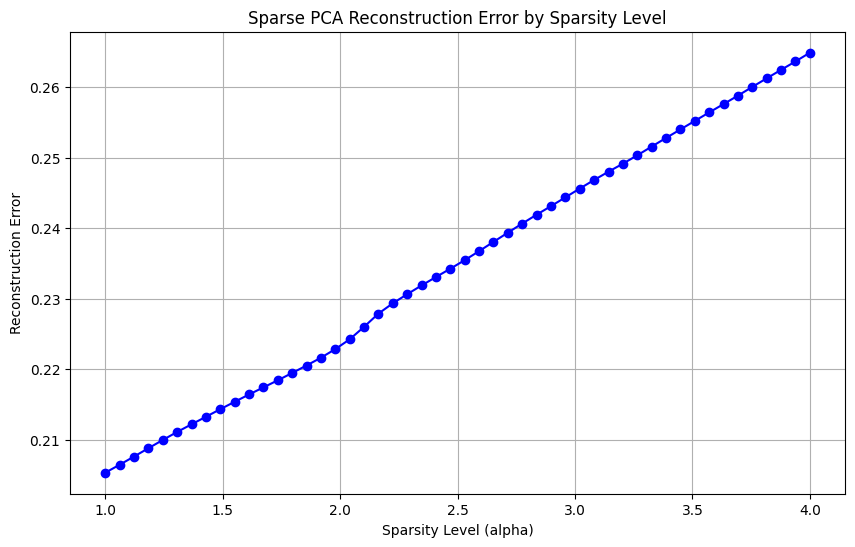

In [55]:
X_scaled = StandardScaler().fit_transform(X)

sparsity_values = np.linspace(1, 4, 50)
reconstruction_errors = []

best_sparsity = None
lowest_reconstruction_error = float('inf')

# Test different sparsity levels
for sparsity in sparsity_values:
    # Sparse PCA
    spca = SparsePCA(n_components=5, alpha=sparsity, random_state=1)
    spca.fit(X_scaled)
    X_reconstructed = spca.transform(X_scaled).dot(spca.components_) + np.mean(X_scaled, axis=0)
    
    # Calculate and store reconstruction error
    reconstruction_error = mean_squared_error(X_scaled, X_reconstructed)
    reconstruction_errors.append(reconstruction_error)

    if reconstruction_error < lowest_reconstruction_error:
        lowest_reconstruction_error = reconstruction_error
        best_sparsity = sparsity


print(f"Best sparsity level: {best_sparsity}")

# Plotting the reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(sparsity_values, reconstruction_errors, marker='o', linestyle='-', color='b')
plt.title('Sparse PCA Reconstruction Error by Sparsity Level')
plt.xlabel('Sparsity Level (alpha)')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

### RGCCA

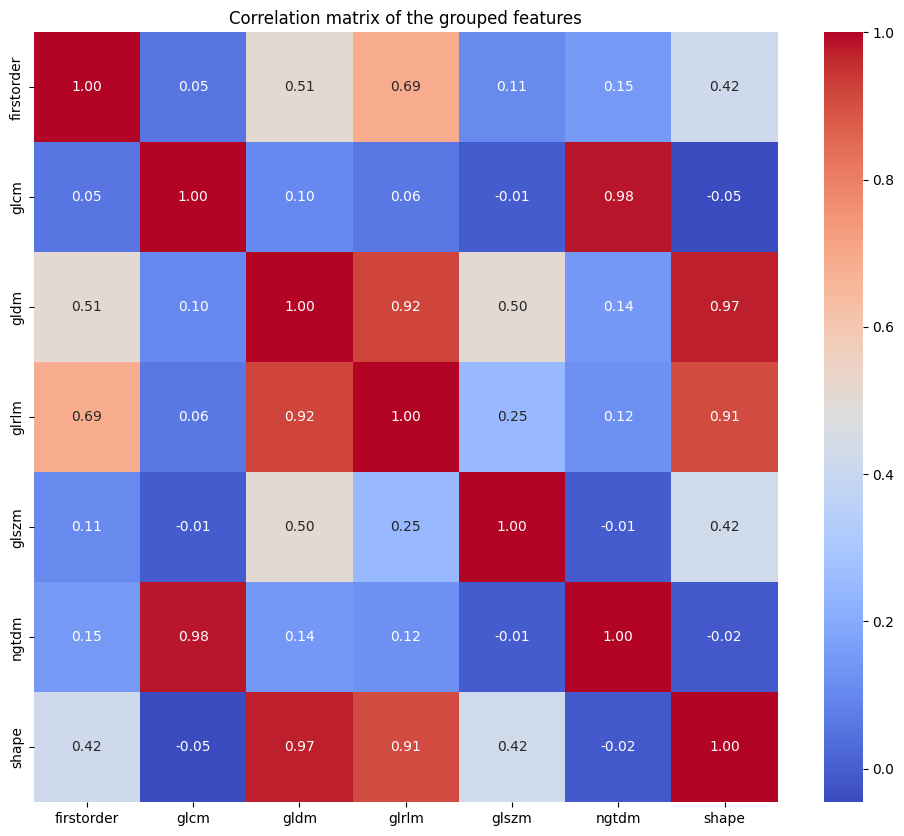

In [99]:
# Group by by the second term of str.split('_') and compute the mean
X_grouped = X.groupby(X.columns.str.split('_').str[2], axis=1).mean()

# Compute the correlation matrix
R_grouped = X_grouped.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(R_grouped, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix of the grouped features")
plt.show()


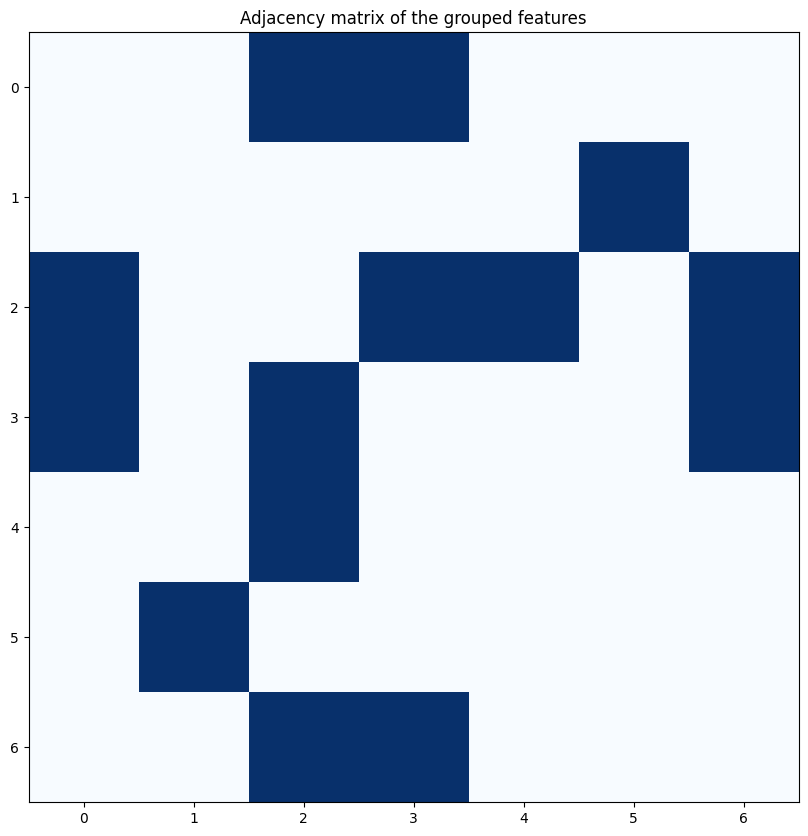

In [108]:
# Build an adjacency matrix based on the correlation matrix and put 1 if the correlation is above 0.4
adjacency_matrix = (R_grouped.abs() > 0.5).astype(int)

# Put zeros on the diagonal
np.fill_diagonal(adjacency_matrix.values, 0)

# Plot the adjacency matrix
plt.figure(figsize=(12, 10))
plt.imshow(adjacency_matrix, cmap='Blues')
plt.title("Adjacency matrix of the grouped features")
plt.show()


In [110]:
np.array(adjacency_matrix)

array([[0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0]])

In [116]:
# Group firstorder features together
firstorder_features = [col for col in X.columns if 'firstorder' in col]
shape_features = [col for col in X.columns if 'shape' in col]
texture_features = []

# Collect texture-related features
for texture_type in ['glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm']:
    texture_features.extend([col for col in X.columns if texture_type in col])

# Create a new DataFrame to hold the grouped features
X_grouped = pd.DataFrame()

# Calculate the mean of the groups and store them in the new DataFrame
X_grouped['firstorder'] = X[firstorder_features].mean(axis=1)
X_grouped['shape'] = X[shape_features].mean(axis=1)
X_grouped['texture'] = X[texture_features].mean(axis=1)  # Average of all texture-related features

# Display the new DataFrame structure
X_grouped.head()


,firstorder,shape,texture
ID,,,
0,1.605006e+08,4416.152238,219.481045
1,4.454368e+08,2447.099726,9076.365062
4,1.050804e+07,1213.670879,163.586733
5,5.761513e+06,141.729736,11.505127
6,7.144970e+09,53491.183409,1106.635463


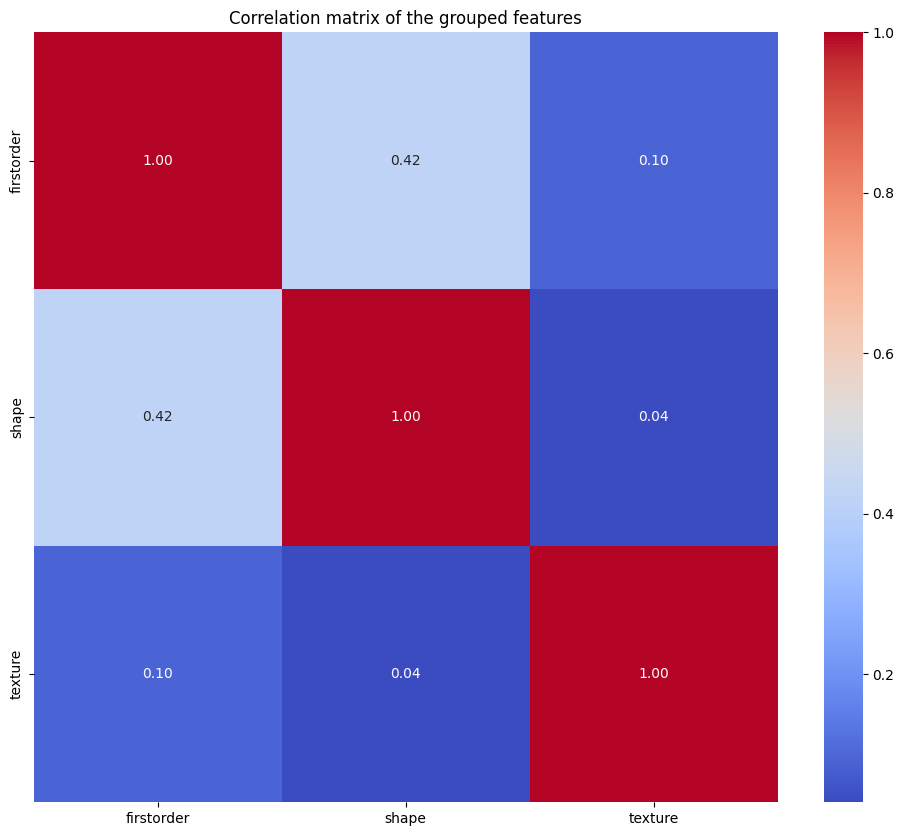

In [117]:
# Compute the correlation matrix
R_grouped = X_grouped.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(R_grouped, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix of the grouped features")
plt.show()

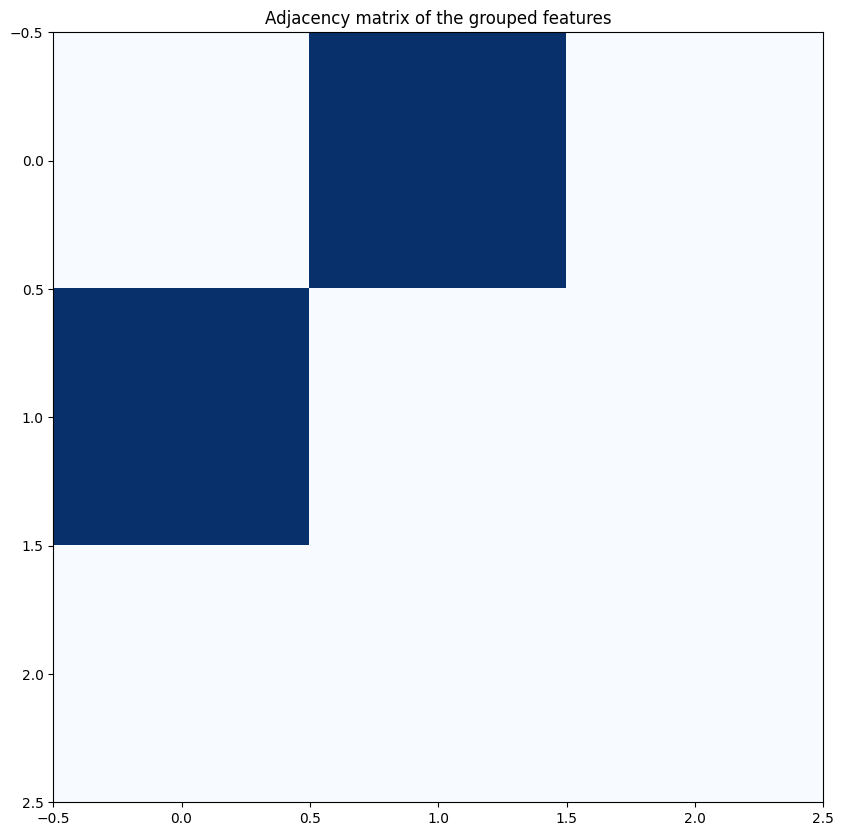

In [118]:
# Build an adjacency matrix based on the correlation matrix and put 1 if the correlation is above 0.4
adjacency_matrix = (R_grouped.abs() > 0.4).astype(int)

# Put zeros on the diagonal
np.fill_diagonal(adjacency_matrix.values, 0)

# Plot the adjacency matrix
plt.figure(figsize=(12, 10))
plt.imshow(adjacency_matrix, cmap='Blues')
plt.title("Adjacency matrix of the grouped features")
plt.show()

In [119]:
np.array(adjacency_matrix)

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 0]])

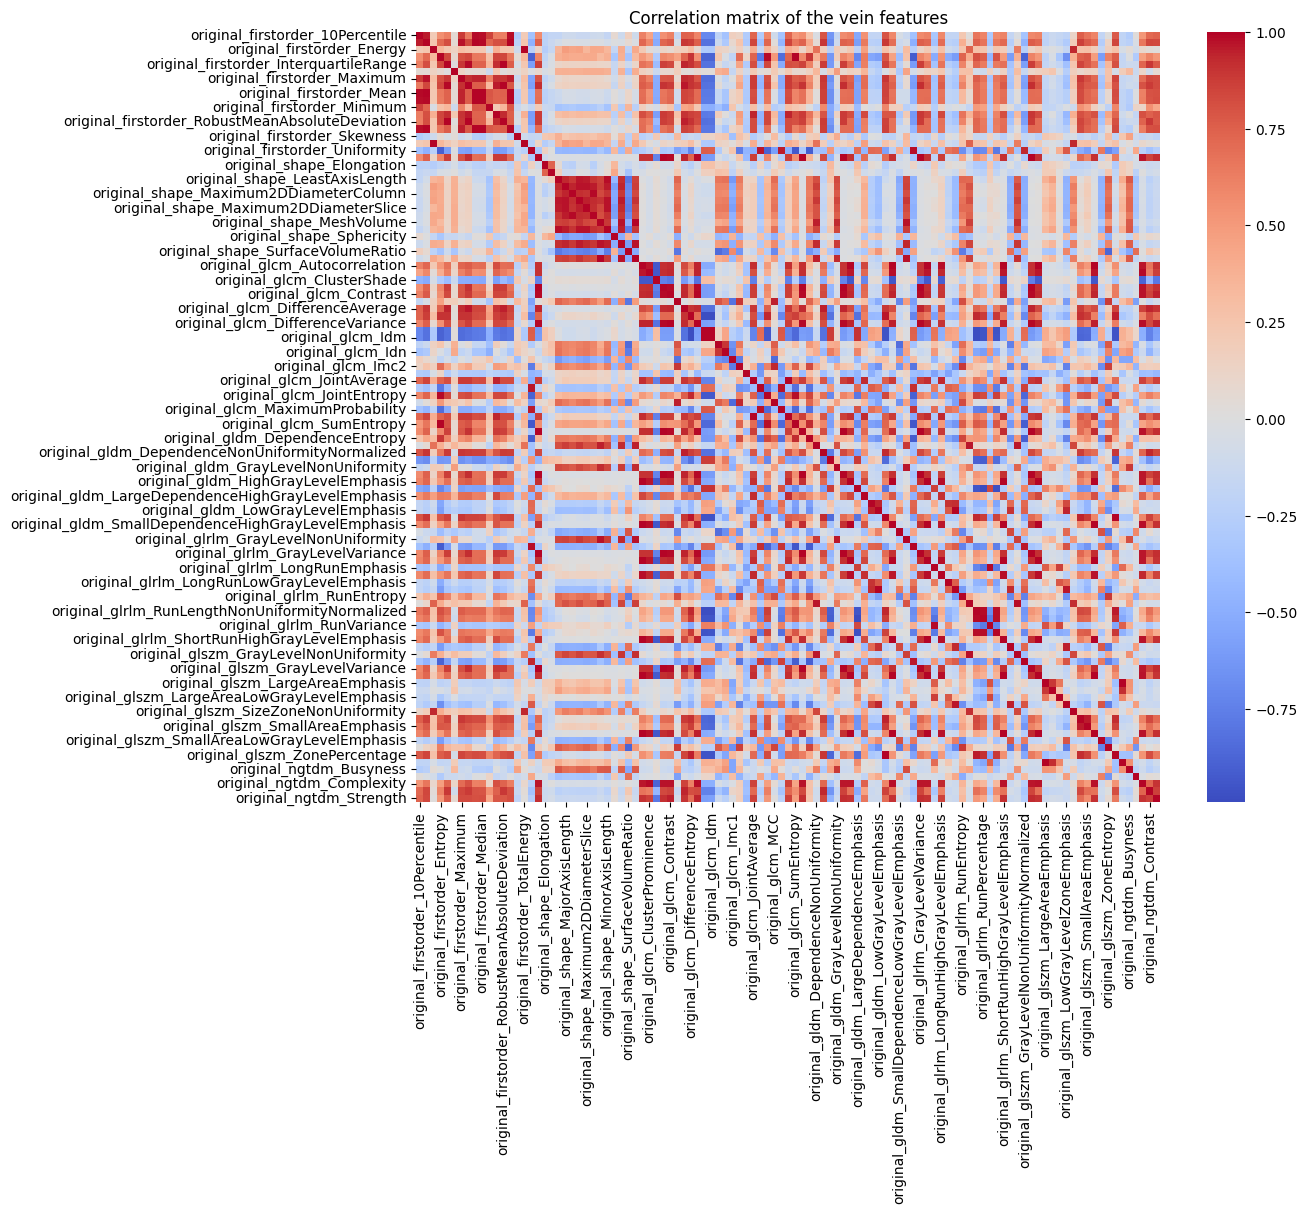

In [93]:
vein_features = X.filter(like='VEIN_', axis=1)
vein_features.columns = vein_features.columns.str.replace('VEIN_', '')

# Compute the correlation matrix of vein features
vein_corr = vein_features.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(vein_corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix of the vein features")
plt.show()


Here we consider $J$ data matrices $X_1,...X_J$ with $J=7$ where each $n \times p_j$ matrix $X_j$ is a block and represents a set of $p_j$ variables observed on $n$ individuals. The objective of RGCCA is to find, for each block $X_j$ a weighted composite of variables $y_j = X_ja_j$ summarizing the relevant information between and within the blocks. The block components are obtained such that (i) block components explain well their own block and/or (ii) block components that are assumed to be connected are highly correlated.

It's defined as the following optimization problem:

$$
\underset{\mathbf{a}_1, \ldots, \mathbf{a}_J}{\operatorname{maximize}} \sum_{j, k=1}^J c_{j k} g\left(\operatorname{cov}\left(\mathbf{X}_j \mathbf{a}_j, \mathbf{X}_k \mathbf{a}_k\right)\right) \text { s.t. }\left(1-\tau_j\right) \operatorname{var}\left(\mathbf{X}_j \mathbf{a}_j\right)+\tau_j\left\|\mathbf{a}_j\right\|^2=1$$

In [156]:
y_encoded = pd.DataFrame(columns=list(['CCK','CHC','Mixtes']))

y_encoded['CCK'] = (y=='CCK').astype(int)
y_encoded['CHC'] = (y=='CHC').astype(int)
y_encoded['Mixtes'] = (y=='Mixtes').astype(int)

In [158]:
vein_features = X.filter(like='VEIN_', axis=1)
vein_features.columns = vein_features.columns.str.replace('VEIN_', '')

vein_features_scaled = StandardScaler().fit_transform(vein_features)
df = pd.DataFrame(vein_features_scaled, index=vein_features.index)
df.columns = vein_features.columns

new_df = pd.concat([df,y_encoded],axis=1)

new_df.to_csv('data/processed/global_radio_rgcca.csv', index=False)

### Analyse Multiway | CP/PARAFAC

L'[article](https://hal.science/hal-04257688/document) propose une extension de PARAFAC pour des données dépendant de 3 axes individu × grandeur × temps. Chaque individu est ainsi décrit par un ensemble de variables longitudinales avec pour chacune d’elle un échantillonnage qui lui est propre.

Il est montré que dans le contexte d’un échantillonnage irrégulier et très parcimonieux, il est possible de conserver une qualité d’estimation des facteurs et des fonctions canoniques en observant un plus grand nombre d’individus.

Cette version fonctionnelle repose principalement sur une reformulation de PARAFAC ne dépendant plus des données, mais uniquement des fonctions de covariance. Ces dernières sont estimées par une technique d’agrégation et de lissage.

On note ici $i \in [1,147]$ l’indice correspondant à l’individu et $k \in [1,107]$ l’indice correspondant aux grandeurs observées. Pour un individu et une grandeur donnés, notons $t_{i,k}$ le vecteur dont les éléments sont les $q_{i,k}$ instants d’observation e.g $t_{i,k}$ est un vecteur de taille 1,2,3 ou 4 (ART > PORT > VEIN > TARD).

In [261]:
df = global_radio_complete.copy()
wide_df = df.unstack(level='temps_inj')
X = wide_df.drop(['classe_name'],axis=1)
y = wide_df['classe_name']['ART']

X.head()

original_firstorder_10Percentile                       \
temps_inj                              ART   PORT   VEIN   TARD   
ID                                                                
0                                    211.0  256.0  264.0  253.0   
1                                    260.1  229.0  229.1  212.0   
4                                    110.0  130.0  134.0  143.0   
5                                    162.7  341.7  333.6  346.4   
6                                    399.0  484.0  496.0  488.0   

          original_firstorder_90Percentile                         \
temps_inj                              ART   PORT    VEIN    TARD   
ID                                                                  
0                                    367.0  362.0   359.0   341.0   
1                                    894.0  954.8  1144.7  1120.9   
4                                    166.0  171.0   167.0   168.0   
5                                    277.3  445.3   416.7   402.6   
6                                    638.0  671.0   673.0   651.0   

          original_firstorder_Energy                ...  \
temps_inj                        ART          PORT  ...   
ID                                                  ...   
0                       3.015106e+08  3.356713e+08  ...   
1                       7.323840e+08  7.720563e+08  ...   
4                       1.982289e+07  1.992656e+07  ...   
5                       4.416506e+06  1.807627e+07  ...   
6                       1.289387e+10  1.594912e+10  ...   

          original_ngtdm_Complexity              original_ngtdm_Contrast  \
temps_inj                      VEIN         TARD                     ART   
ID                                                                         
0                         39.277987    38.563334                0.053328   
1                      11442.875990  7286.155315                0.312577   
4                          1.508313     1.566126                0.018048   
5                         13.409998     7.369850                0.118901   
6                        596.169662   493.969070                0.036039   

                                        original_ngtdm_Strength            \
temps_inj      PORT      VEIN      TARD                     ART      PORT   
ID                                                                          
0          0.014902  0.015188  0.013078                0.226864  0.534732   
1          0.370738  0.449753  0.514460                5.425102  5.795566   
4          0.012486  0.013621  0.009396                0.224467  0.121753   
5          0.086435  0.057493  0.086926                1.455775  1.305156   
6          0.020776  0.026698  0.024221                0.140786  0.236058   

                               
temps_inj      VEIN      TARD  
ID                             
0          0.332041  0.379284  
1          9.512513  6.745733  
4          0.061704  0.053781  
5          1.083879  0.645670  
6          0.187567  0.157278  

[5 rows x 428 columns]

In [254]:
df = global_radio_clean.copy()
new = df.set_index(['ID', 'temps_inj'])
wide_df = new.unstack(level='temps_inj')
X = wide_df.drop(['classe_name'],axis=1)
y = wide_df['classe_name']['ART']

X.head()

original_firstorder_10Percentile                       \
temps_inj                              ART   PORT   VEIN   TARD   
ID                                                                
0                                    211.0  256.0  264.0  253.0   
1                                    260.1  229.0  229.1  212.0   
2                                    178.0  211.0    NaN  233.0   
3                                     67.0    NaN  101.0   86.0   
4                                    110.0  130.0  134.0  143.0   

          original_firstorder_90Percentile                         \
temps_inj                              ART   PORT    VEIN    TARD   
ID                                                                  
0                                    367.0  362.0   359.0   341.0   
1                                    894.0  954.8  1144.7  1120.9   
2                                    248.0  289.0     NaN   297.0   
3                                    111.0    NaN   156.0   132.0   
4                                    166.0  171.0   167.0   168.0   

          original_firstorder_Energy               ...  \
temps_inj                        ART         PORT  ...   
ID                                                 ...   
0                        301510584.0  335671262.0  ...   
1                        732384007.0  772056339.0  ...   
2                        383254281.0  508007701.0  ...   
3                        125129137.0          NaN  ...   
4                         19822886.0   19926559.0  ...   

          original_ngtdm_Complexity              original_ngtdm_Contrast  \
temps_inj                      VEIN         TARD                     ART   
ID                                                                         
0                         39.277987    38.563334                0.053328   
1                      11442.875990  7286.155315                0.312577   
2                               NaN    24.791401                0.007099   
3                         13.679928     8.215252                0.007283   
4                          1.508313     1.566126                0.018048   

                                        original_ngtdm_Strength            \
temps_inj      PORT      VEIN      TARD                     ART      PORT   
ID                                                                          
0          0.014902  0.015188  0.013078                0.226864  0.534732   
1          0.370738  0.449753  0.514460                5.425102  5.795566   
2          0.015560       NaN  0.006415                0.117422  0.054773   
3               NaN  0.009523  0.011055                0.018770       NaN   
4          0.012486  0.013621  0.009396                0.224467  0.121753   

                               
temps_inj      VEIN      TARD  
ID                             
0          0.332041  0.379284  
1          9.512513  6.745733  
2               NaN  0.187115  
3          0.023968  0.011826  
4          0.061704  0.053781  

[5 rows x 428 columns]

In [262]:
X_array = np.array(X).reshape(len(y),-1,4)
y_encoded = LabelEncoder().fit_transform(y)

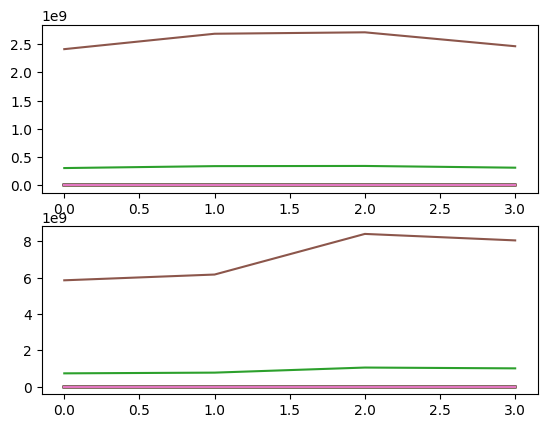

In [263]:
fig, ax = plt.subplots(2)
ax[0].plot(X_array[0].T)
ax[1].plot(X_array[1].T)
plt.show()

[[ 1.27658409e-09  6.02528207e-09]
 [ 2.18661636e-09  9.65398316e-09]
 [ 1.24034735e-01  1.24034735e-01]
 [ 1.21128594e-11  1.57166974e-11]
 [ 4.61228599e-10  2.18197954e-09]
 [ 1.25578021e-11 -3.18461033e-11]
 [ 3.31563924e-09  7.58467918e-09]
 [ 2.84552964e-10  1.26577163e-09]
 [ 1.74580648e-09  7.86892603e-09]
 [ 1.76108445e-09  8.14232197e-09]
 [ 2.79445298e-10  9.11265463e-10]
 [ 3.03619394e-09  6.67341371e-09]
 [ 1.93631021e-10  8.93316355e-10]
 [ 1.78895963e-09  8.12445613e-09]
 [-2.26818021e-13 -2.02889309e-11]
 [ 9.92277877e-01  9.92277877e-01]
 [ 2.79258830e-13 -2.01885800e-12]
 [ 6.01619875e-08  5.20118548e-07]
 [ 1.99693124e-12 -3.14526979e-12]
 [ 1.64473411e-12 -1.47950052e-12]
 [ 2.35761872e-10 -1.27524942e-10]
 [ 4.55571177e-10 -1.84139602e-10]
 [ 4.88175022e-10 -2.29913789e-10]
 [ 4.78406326e-10 -2.61178842e-10]
 [ 3.76702520e-10 -2.28715672e-10]
 [ 5.17661907e-10 -2.66364091e-10]
 [ 2.56045242e-06 -7.54883693e-07]
 [ 2.85844061e-10 -2.18038854e-10]
 [ 2.06799277e-12 -1

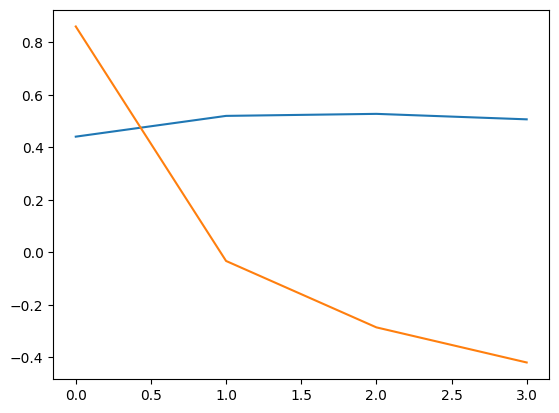

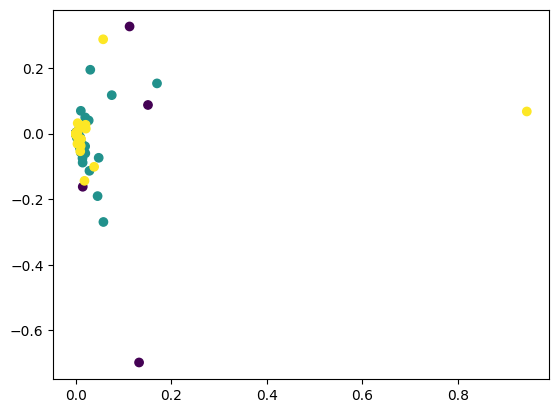

In [267]:
t = ts.tensor(X_array)
weights, factors = parafac(t, rank=2, normalize_factors=True)

plt.figure()
plt.plot(factors[2])
print(factors[1])
plt.figure()
plt.scatter(*zip(*factors[0]), c=y_encoded)

In [280]:
# depliement selon les 3 modes
X1, X2, X3 = [ts.unfold(t, i) for i in range(3)]  

R = 2
U1, U2, U3 = [ts.tensor(np.random.random((n, R))) for n in list(X_array.shape)]

[[ 1.26362712e-09  1.26610466e-09]
 [ 2.25423246e-09  2.24774427e-09]
 [ 1.24034735e-01  1.24034735e-01]
 [ 1.26298978e-11  1.25695992e-11]
 [ 5.10789775e-10  5.05284539e-10]
 [ 1.26675810e-11  1.26457542e-11]
 [ 3.59430322e-09  3.56226921e-09]
 [ 3.10926197e-10  3.08009765e-10]
 [ 1.77528959e-09  1.77303314e-09]
 [ 1.79206402e-09  1.78968253e-09]
 [ 2.64835690e-10  2.66685980e-10]
 [ 3.32946753e-09  3.29558323e-09]
 [ 2.13685493e-10  2.11458531e-10]
 [ 1.82507799e-09  1.82208090e-09]
 [-5.64696543e-14 -8.05810413e-14]
 [ 9.92277877e-01  9.92277877e-01]
 [ 2.75826363e-13  2.75772357e-13]
 [ 6.87129724e-08  6.77957085e-08]
 [ 2.04376487e-12  2.03721059e-12]
 [ 1.68287164e-12  1.67774673e-12]
 [ 2.41649216e-10  2.40881846e-10]
 [ 4.67173342e-10  4.65676312e-10]
 [ 5.00612721e-10  4.99001429e-10]
 [ 4.90708445e-10  4.89108858e-10]
 [ 3.86247511e-10  3.85000108e-10]
 [ 5.30987229e-10  5.29258010e-10]
 [ 2.62533480e-06  2.61701538e-06]
 [ 2.93160857e-10  2.92196701e-10]
 [ 2.12252268e-12  2

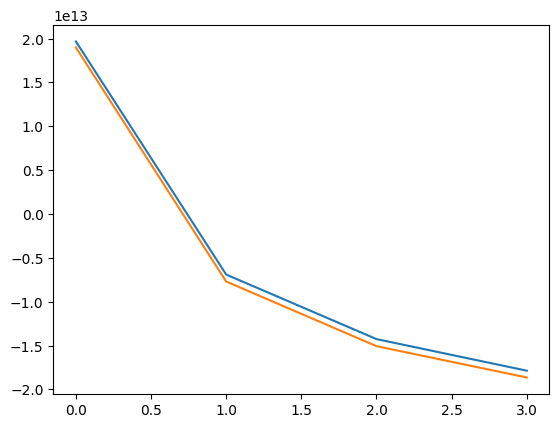

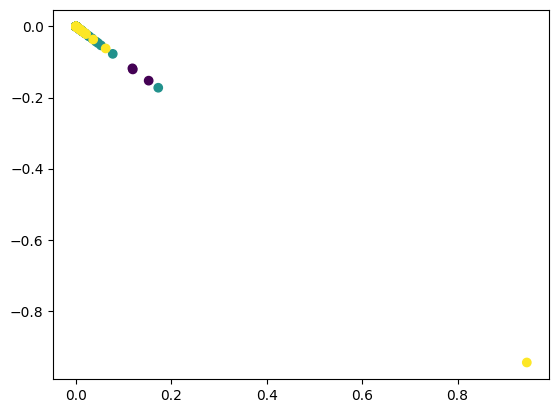

In [281]:
for i in range(1000):
    
    Mat = ts.tenalg.khatri_rao([U2,U3])

    Mmp = (U3.T @ U3) * (U2.T@U2)
    U1 = X1 @ Mat @ np.linalg.inv(Mmp)
    U1 = U1@np.diag(1/np.sqrt(np.diag(U1.T@U1)))

    #Mat = ts.kr([U1, U3])
    Mat = ts.tenalg.khatri_rao([U1, U3])

    Mmp = (U3.T @ U3) * (U1.T@U1)
    U2 = X2 @ Mat @ np.linalg.inv(Mmp)
    U2 = U2@np.diag(1/np.sqrt(np.diag(U2.T@U2)))

    #Mat = ts.kr([U1, U2])
    Mat = ts.tenalg.khatri_rao([U1, U2])

    Mmp = (U2.T @ U2) * (U1.T@U1)
    U3 = X3 @ Mat @ np.linalg.inv(Mmp)

plt.figure()
plt.plot(U3)
print(U2)
plt.figure()
plt.scatter(*zip(*U1), c=y_encoded)


### Simple ML models

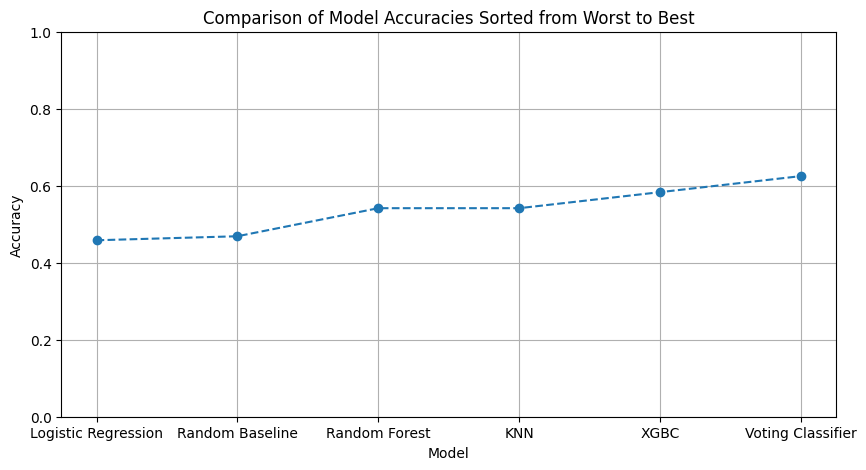

In [82]:
# Encode y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_functions = [logistic_regression, random_forest, xgbc, knn, voting_classifier]
model_names = ["Random Baseline", "Logistic Regression", "Random Forest", "XGBC", "KNN", "Voting Classifier"]
accuracies = [compute_random_baseline(y_test)]

for train_func in model_functions:
    acc = train_func(X_train, y_train, X_test, y_test)
    accuracies.append(acc)


# Sort models by accuracy
sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k])
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Plotting the results with a line plot and dotted lines
plt.figure(figsize=(10, 5))
plt.plot(sorted_model_names, sorted_accuracies, 'o--')  # 'o--' denotes dotted line with markers
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies Sorted from Worst to Best')
plt.ylim([0, 1])  # Assuming accuracy scores between 0 and 1
plt.grid(True)
plt.show()


### Viz

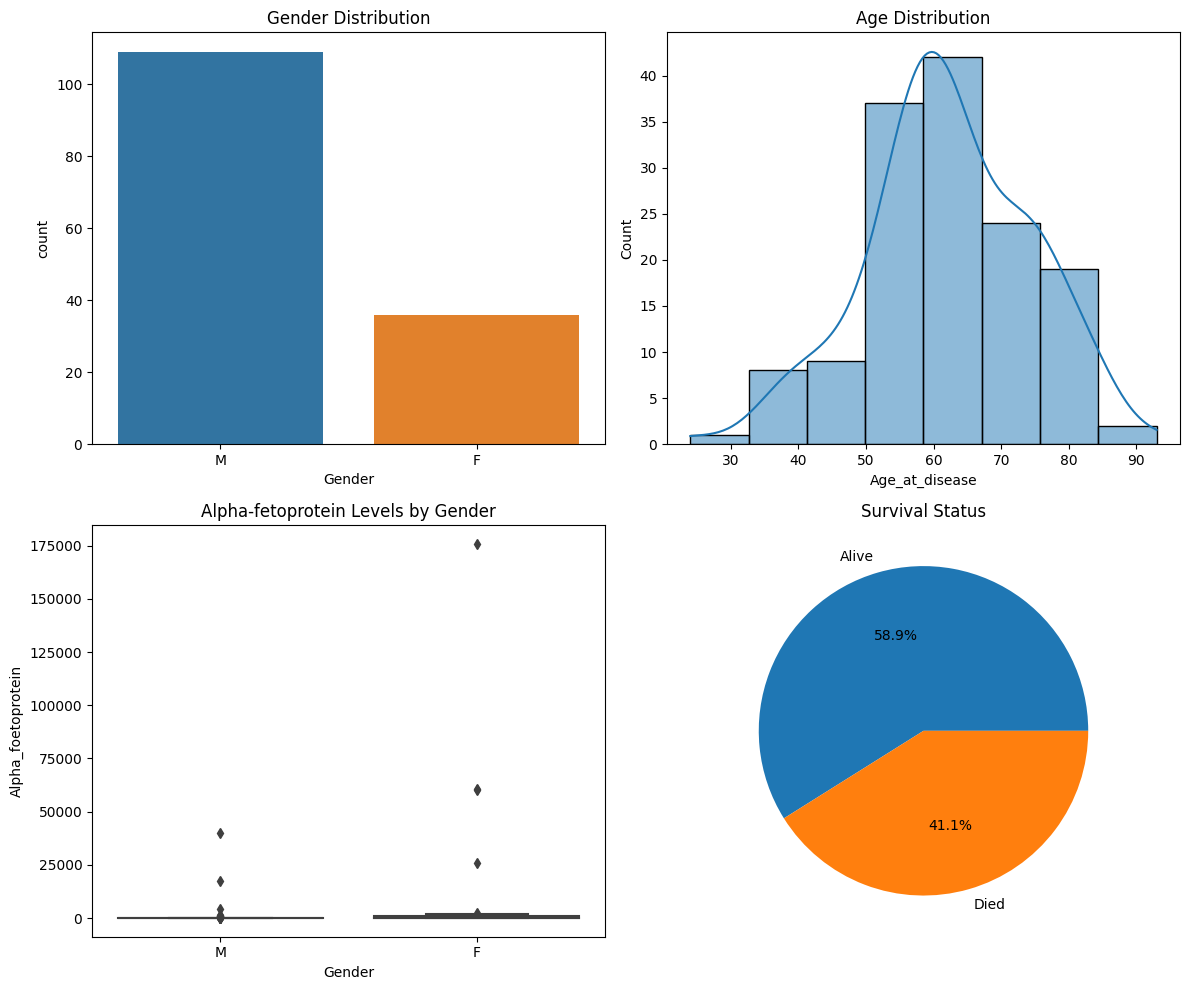

In [29]:
# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Gender Distribution
sns.countplot(x='Gender', data=desc, ax=axes[0, 0])
axes[0, 0].set_title('Gender Distribution')

# Age Distribution
sns.histplot(desc['Age_at_disease'], bins=8, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution')

# Alpha-fetoprotein Levels by Gender
sns.boxplot(x='Gender', y='Alpha_foetoprotein', data=desc, ax=axes[1, 0])
axes[1, 0].set_title('Alpha-fetoprotein Levels by Gender')

# Survival Status
death_counts = desc['Death'].value_counts()
axes[1, 1].pie(death_counts, labels=death_counts.index.map({0: 'Alive', 1: 'Died'}), autopct='%1.1f%%')
axes[1, 1].set_title('Survival Status')

plt.tight_layout()
plt.show()

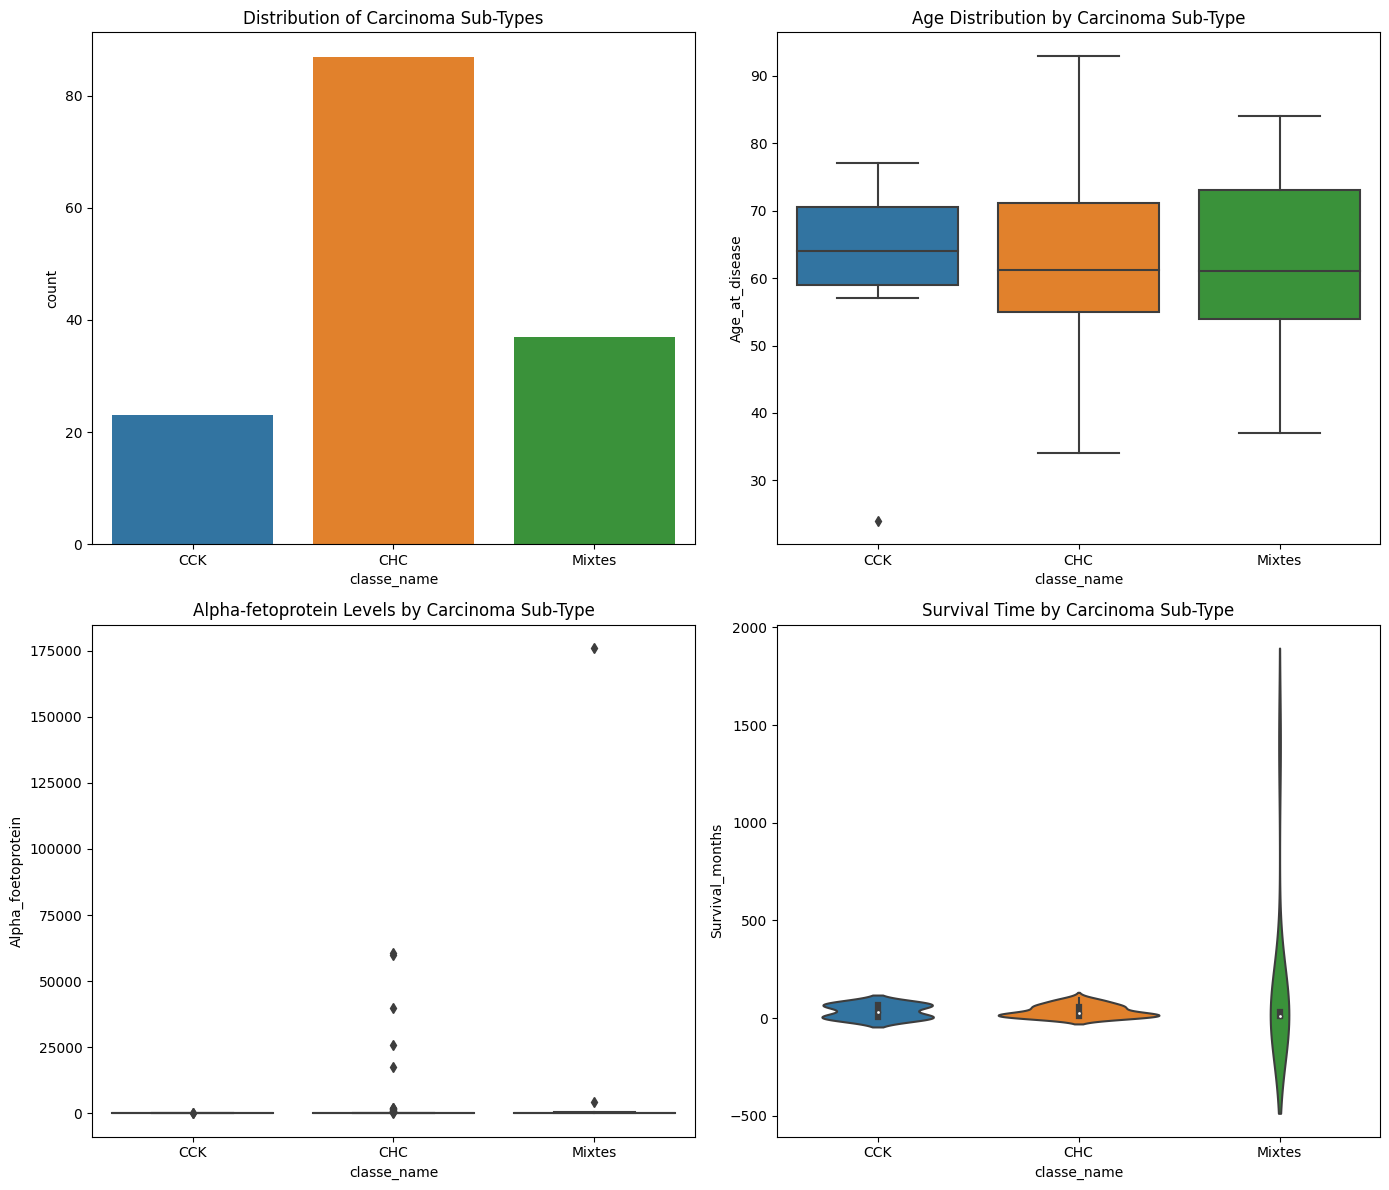

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

# Count of Each Carcinoma Sub-Type
sns.countplot(x='classe_name', data=desc, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Carcinoma Sub-Types')

# Distribution of Age by Carcinoma Sub-Type
sns.boxplot(x='classe_name', y='Age_at_disease', data=desc, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Carcinoma Sub-Type')

# Alpha-fetoprotein Levels by Carcinoma Sub-Type
sns.boxplot(x='classe_name', y='Alpha_foetoprotein', data=desc, ax=axes[1, 0])
axes[1, 0].set_title('Alpha-fetoprotein Levels by Carcinoma Sub-Type')

# Survival Months by Carcinoma Sub-Type
sns.violinplot(x='classe_name', y='Survival_months', data=desc, ax=axes[1, 1])
axes[1, 1].set_title('Survival Time by Carcinoma Sub-Type')

plt.tight_layout()
plt.show()



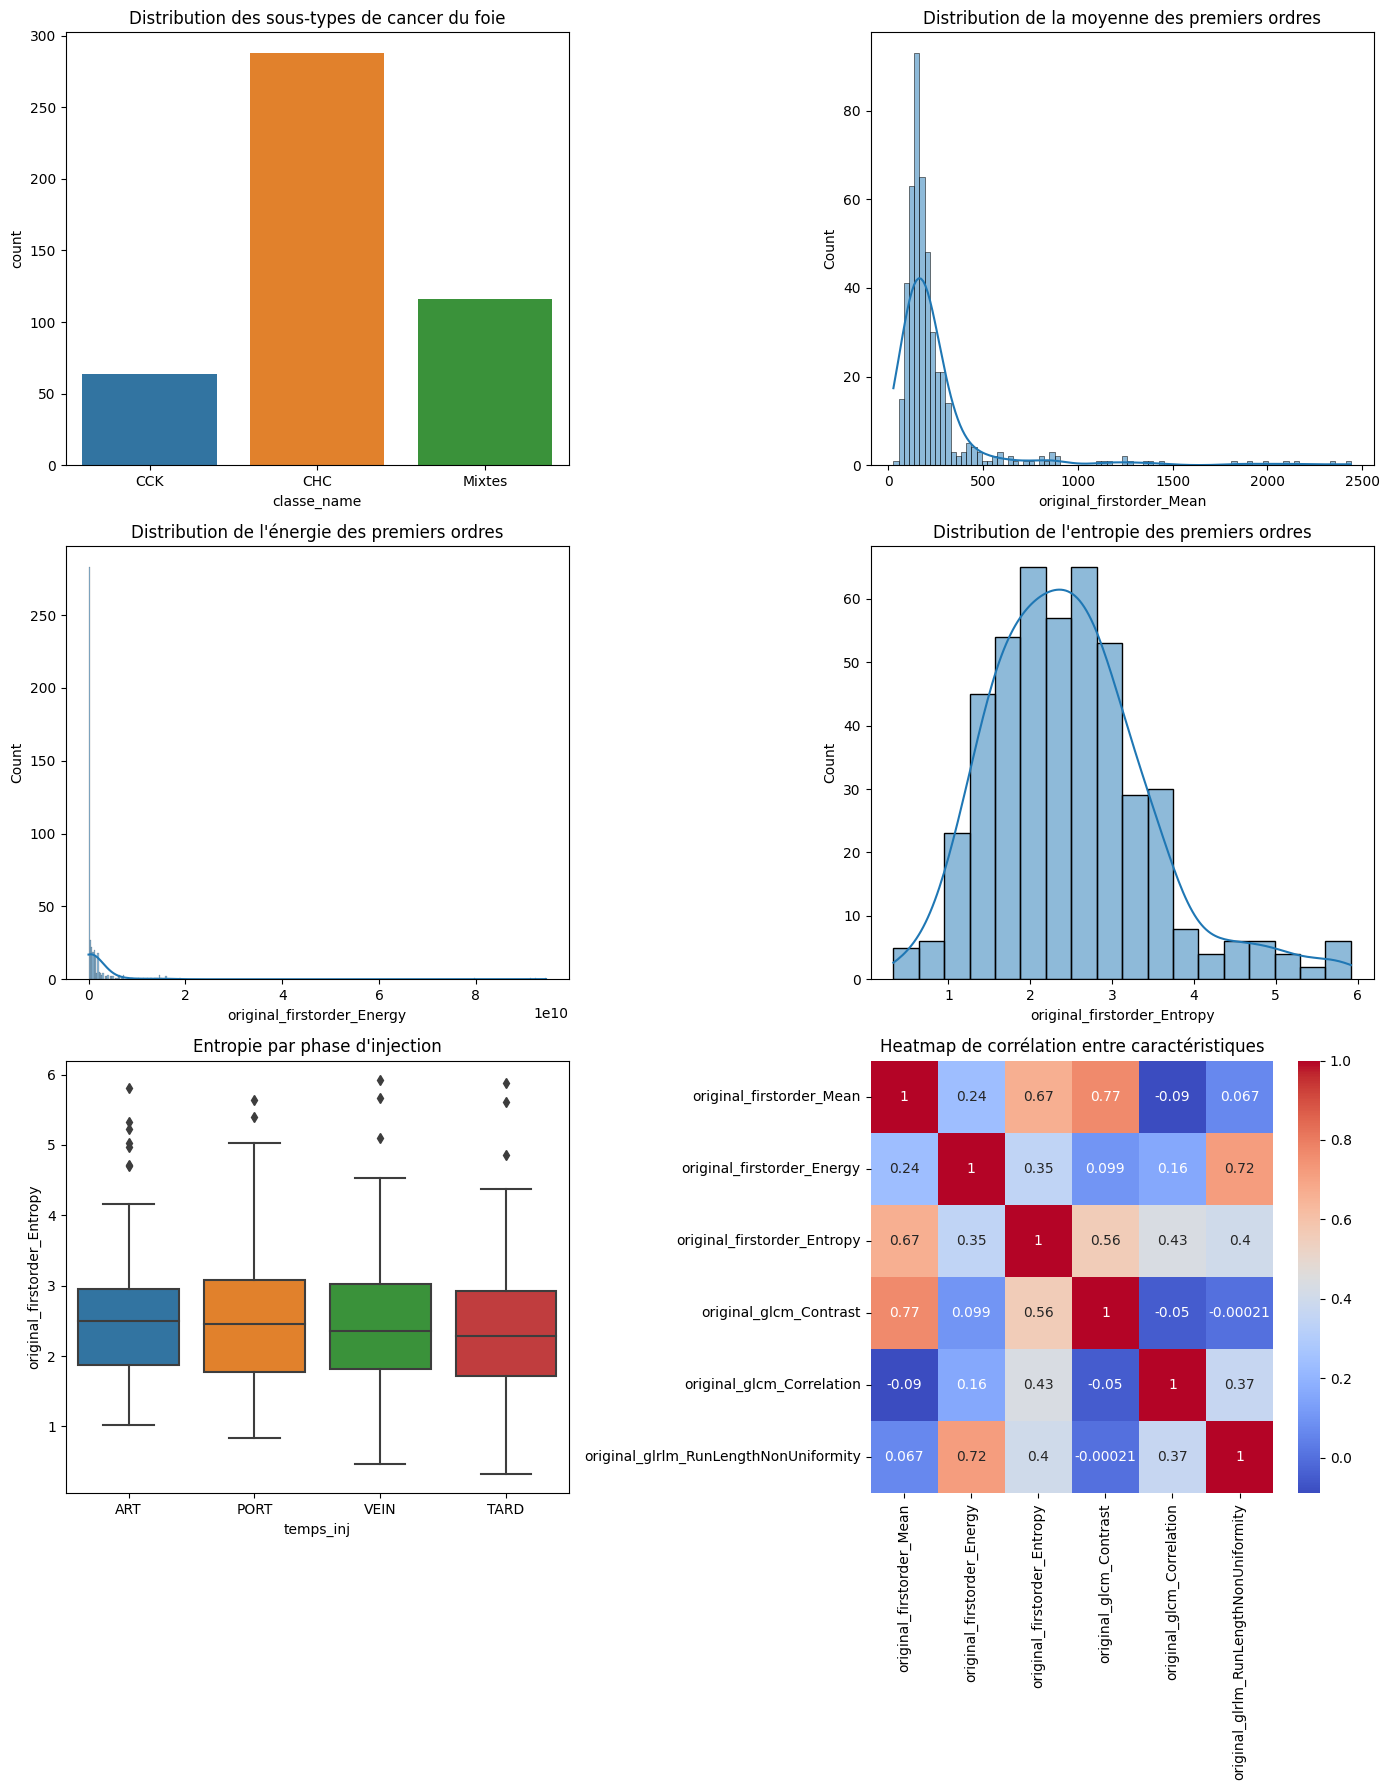

In [31]:
# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

# Distribution des sous-types de cancer du foie
sns.countplot(x='classe_name', data=global_radio_complete, ax=axes[0, 0])
axes[0, 0].set_title('Distribution des sous-types de cancer du foie')

# Histogrammes pour Mean, Energy, Entropy
sns.histplot(global_radio_complete['original_firstorder_Mean'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution de la moyenne des premiers ordres')

sns.histplot(global_radio_complete['original_firstorder_Energy'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution de l\'énergie des premiers ordres')

sns.histplot(global_radio_complete['original_firstorder_Entropy'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution de l\'entropie des premiers ordres')

# Boxplot pour l'entropie par phase d'injection
sns.boxplot(x='temps_inj', y='original_firstorder_Entropy', data=global_radio_complete, ax=axes[2, 0])
axes[2, 0].set_title('Entropie par phase d\'injection')

# Correlation heatmap for selected features
correlation_features = ['original_firstorder_Mean', 'original_firstorder_Energy', 'original_firstorder_Entropy', 
                        'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glrlm_RunLengthNonUniformity']
corr_matrix = global_radio_complete[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[2, 1])
axes[2, 1].set_title('Heatmap de corrélation entre caractéristiques')

plt.tight_layout()
plt.show()

### Experiments